# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
 
from sklearn.preprocessing import MinMaxScaler, StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

from xgboost import XGBClassifier
from xgboost import plot_importance

from time import time

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Data Cleaning : Portfolio

In [4]:
# Rename portfolio id column to offer_id column to remove confusion between different id column in other dataframes
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
def dummies(df, feature):
    '''
    Input:   df: dataset
             feature: feature to be worked on
    Output:  df: dataset
    provides one-hot encoding for dataset with selected feature
    
    '''
    
    
    df_temp=pd.get_dummies(data=df[feature])
    df=pd.concat([df, df_temp], axis=1)
    df.drop(feature,axis=1, inplace=True)
    
    return df

In [7]:
df_portfolio=dummies(portfolio, 'offer_type')

In [8]:
df_portfolio

,reward,channels,difficulty,duration,offer_id,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
5,3,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
6,2,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
7,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1
8,5,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
9,2,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0


In [9]:
# Converting Channels variable into respective columns
unq_channels=list(set(itertools.chain(*portfolio['channels'].tolist())))
for channel in unq_channels:
    df_portfolio[channel] = df_portfolio.channels.apply(lambda x:1 if channel in x else 0 )
df_portfolio.drop('channels', axis=1, inplace=True)   

In [10]:
df_portfolio

,reward,difficulty,duration,offer_id,bogo,discount,informational,social,web,mobile,email
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,0,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,0,1,1,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,1,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,0,1,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,1,1,1


In [11]:
df_portfolio.sum()

reward                                                          42
difficulty                                                      77
duration                                                        65
offer_id         ae264e3637204a6fb9bb56bc8210ddfd4d5c57ea9a6940...
bogo                                                             4
discount                                                         4
informational                                                    2
social                                                           6
web                                                              8
mobile                                                           9
email                                                           10
dtype: object

# Transcript

In [12]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Data Cleaning : Transcript

In [13]:
#rename column id to customer_id for future merging purpose
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [14]:
#Change and rouding off the time in hours into days for better understanding 
transcript['days'] = transcript.time.apply(lambda x: round(x/24.0))
#transcript.rename(columns={'time':'days'}, inplace=True)
transcript


,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [15]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [16]:
transcript[transcript['event']=='transaction']

,customer_id,event,value,time,days
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [17]:
transcript[transcript['event']=='offer received']

,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,24
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,24
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24


In [18]:
transcript[transcript.event!='transaction']['value']

0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                        
306497    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
306506    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306507     {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
306509    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306527    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
Name: value, Length: 167581, dtype: object

In [19]:
transcript.loc[306509]['value']

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [20]:
transcript[transcript.event!='transaction']

,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,30
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,30
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,30


Spliting transcript dataset into different dataset

In [21]:
#Transaction has amount variable under value, and offer received, offer viewed and offer completed has offer id
#Extract the variables from value column 
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', np.nan))
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id',np.nan)))
transcript.drop('value',inplace=True, axis=1)

In [22]:
transcript

,customer_id,event,time,days,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


In [23]:
transcript_offer=transcript[transcript['amount'].isnull()]
transcript_offer.drop('amount', axis=1, inplace=True)
transcript_offer['event'].unique()



array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [24]:
transcript_offer.reset_index(inplace=True, drop=True)
transcript_offer

,customer_id,event,time,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,30,0b1e1539f2cc45b7b9fa7c272da2e1d7
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4


In [25]:
df_temp=pd.get_dummies(data=transcript_offer.event )
df_transcript_offer=pd.concat([transcript_offer,df_temp], axis=1)
df_transcript_offer.rename({'offer completed':'completed','offer received':'received', 'offer viewed': 'viewed'},axis=1, inplace= True)
df_transcript_offer

,customer_id,event,time,days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
...,...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0
167577,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,30,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
167579,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


In [26]:
df_transcript_offer[df_transcript_offer['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,event,time,days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
14928,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1
26541,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
27253,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,7,5a8bc65990b245e5a138643cd4eb9837,0,1,0
50486,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,9,5a8bc65990b245e5a138643cd4eb9837,0,0,1
80822,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,17,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0
93599,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,17,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
109739,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,21,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
125208,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,21,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
125209,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,21,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0


In [27]:
df_new12=df_transcript_offer.sort_values(['customer_id', 'offer_id'])

In [28]:
df_new12.reset_index(drop=True, inplace=True)

In [29]:

df_compost=pd.DataFrame(columns=['customer_id', 'received', 'viewed', 'completed'])

In [30]:
%%time
place=-1
for person in list(df_new12['customer_id'].unique()):
    tup=0
    


    for index, row in df_new12[df_new12['customer_id']==person].iterrows():
        
        if row.offer_id!=tup:
            place+=1
            
        df_compost.at[place, 'customer_id']=row['customer_id']
        df_compost.at[place, 'offer_id']=row['offer_id']
    
        if row['event']=='offer received':
            df_compost.at[place,'received']=1
        
        if row['event']=='offer viewed':
            df_compost.at[place,'viewed']=1
        
        if row['event']=='offer completed':
            df_compost.at[place,'completed']=1 

        tup=row.offer_id

Wall time: 29min 22s


In [31]:

df_compost

,customer_id,received,viewed,completed,offer_id
0,0009655768c64bdeb2e877511632db8f,1,NaN,1,2906b810c7d4411798c6938adc9daaa5
1,0009655768c64bdeb2e877511632db8f,1,1,NaN,3f207df678b143eea3cee63160fa8bed
2,0009655768c64bdeb2e877511632db8f,1,1,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
63284,ffff82501cea40309d5fdd7edcca4a07,1,1,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
63285,ffff82501cea40309d5fdd7edcca4a07,1,1,1,2906b810c7d4411798c6938adc9daaa5
63286,ffff82501cea40309d5fdd7edcca4a07,1,1,1,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [32]:
df_compost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 5 columns):
customer_id    63288 non-null object
received       63288 non-null object
viewed         49135 non-null object
completed      28996 non-null object
offer_id       63288 non-null object
dtypes: object(5)
memory usage: 5.4+ MB


In [33]:
df_compost.fillna(0, inplace=True)

In [34]:
df_compost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 5 columns):
customer_id    63288 non-null object
received       63288 non-null int64
viewed         63288 non-null int64
completed      63288 non-null int64
offer_id       63288 non-null object
dtypes: int64(3), object(2)
memory usage: 5.4+ MB


#### Checkpoint

In [35]:
df_compost.to_csv('df_compost', index=False)

In [36]:

transcript_offer_received=transcript_offer[transcript_offer['event']=='offer received']
transcript_offer_received.reset_index(inplace=True,drop=True)
transcript_offer_received

,customer_id,event,time,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,offer received,576,24,ae264e3637204a6fb9bb56bc8210ddfd
76273,cb23b66c56f64b109d673d5e56574529,offer received,576,24,2906b810c7d4411798c6938adc9daaa5
76274,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,576,24,2298d6c36e964ae4a3e7e9706d1fb8c2
76275,9dc1421481194dcd9400aec7c9ae6366,offer received,576,24,ae264e3637204a6fb9bb56bc8210ddfd


In [37]:
transcript_offer_viewed=transcript_offer[transcript_offer['event']=='offer viewed']
transcript_offer_viewed.reset_index(inplace=True,drop=True)
transcript_offer_viewed

,customer_id,event,time,days,offer_id
0,389bc3fa690240e798340f5a15918d5c,offer viewed,0,0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,offer viewed,0,0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,offer viewed,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,0,5a8bc65990b245e5a138643cd4eb9837
...,...,...,...,...,...
57720,d56386cf344c4829bbf420d1895dca37,offer viewed,714,30,5a8bc65990b245e5a138643cd4eb9837
57721,9b51e8797290403b90d09d864dec4b94,offer viewed,714,30,3f207df678b143eea3cee63160fa8bed
57722,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,30,5a8bc65990b245e5a138643cd4eb9837
57723,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,30,3f207df678b143eea3cee63160fa8bed


In [38]:
transcript_offer_completed=transcript_offer[transcript_offer['event']=='offer completed']
transcript_offer_completed.reset_index(inplace=True,drop=True)
transcript_offer_completed

,customer_id,event,time,days,offer_id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,0,2906b810c7d4411798c6938adc9daaa5
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,0,fafdcd668e3743c1bb461111dcafc2a4
2,629fc02d56414d91bca360decdfa9288,offer completed,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,676506bad68e4161b9bbaffeb039626b,offer completed,0,0,ae264e3637204a6fb9bb56bc8210ddfd
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
33574,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
33575,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
33576,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4
33577,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4


In [39]:
transcript_trans=transcript[transcript['amount'].notnull()]
transcript_trans.reset_index(inplace=True,drop=True)
transcript_trans

,customer_id,event,time,days,amount,offer_id
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0,0.83,NaN
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,0,34.56,NaN
2,54890f68699049c2a04d415abc25e717,transaction,0,0,13.23,NaN
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,0,19.51,NaN
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,0,18.97,NaN
...,...,...,...,...,...,...
138948,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
138949,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
138950,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
138951,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


In [40]:
trans_amt=pd.DataFrame(transcript_trans.groupby('customer_id')['amount'].sum())
trans_amt.reset_index(inplace=True)
trans_amt

,customer_id,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05
...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98
16574,fff7576017104bcc8677a8d63322b5e1,29.94
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15
16576,fffad4f4828548d1b5583907f2e9906b,88.83


There are some transactions that have done after the offer has been expired. We are including them in successfull offers for now as they also did made the sales.

# Profile

In [41]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [42]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


## Data Cleaning : Profile

In [43]:
#Check for any duplicated entry on profile ID
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile[profile['id'].duplicated()]

,gender,age,id,became_member_on,income


In [44]:
type(profile['became_member_on'][1])

numpy.int64

In [45]:
#Change the "became_member_on" Column data type from int64 to datetime for futher explorations
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [46]:
#add column for date, month and year extracted from became_member_on column
profile['join_year'] = profile['became_member_on'].dt.year
profile['join_month'] = profile['became_member_on'].dt.month
profile['join_day'] = profile['became_member_on'].dt.day
profile.head()

,gender,age,id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4


In [47]:
#rename column id to customer_id for future merging purpose
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [48]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [49]:
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
join_year              0
join_month             0
join_day               0
dtype: int64

In [50]:
profile[profile['gender'].isnull()]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [51]:
profile_df1=profile[profile['income'].isnull()]
profile_df1

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [52]:
#If we look at the NaN values they are  from the same age i.e, 118, let's try to find out if that's the value that NaN corresponds to 

profile[((profile['income'].isnull()) & (profile['gender'].isnull()))]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


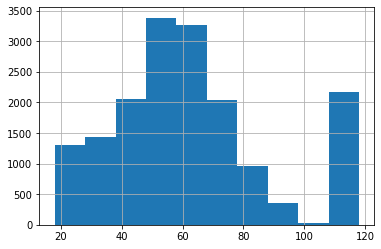

In [53]:
profile.age.hist()

As per my understanding the company/app is putting age 118 as default value where the customer don't want to put their personal details like age, gender and income into the app or the data is simply unavailable.

So, age=118 is an indicator rather than age.

Since, we are missing important parameters like gender, income and age which can be very useful to get a better understanding of the data and is essential for data modelling.

Let's check if we can consider to remove the rows with age=118.

In [54]:
len(profile[profile['age']==118])/len(profile)

0.12794117647058822

Around 13% of customer_id doesn't have information about age, income and gender

Let's check how many of these customer_id has viewed and completed the offer

In [55]:
sort_profile=profile[profile['age']==118]

In [56]:
sort_profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [57]:
complete_profile=sort_profile[(sort_profile.customer_id.isin(transcript_offer_completed.customer_id)) & (sort_profile.customer_id.isin(transcript_offer_viewed.customer_id))]
complete_profile.reset_index(inplace=True,drop=True)
complete_profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN,2016,11,22
2,None,118,c4863c7985cf408faee930f111475da3,2017-08-24,NaN,2017,8,24
3,None,118,148adfcaa27d485b82f323aaaad036bd,2015-09-19,NaN,2015,9,19
4,None,118,65aba5c617294649aeb624da249e1ee5,2017-03-30,NaN,2017,3,30
...,...,...,...,...,...,...,...,...
780,None,118,1efb4a45f5c34db4b07ebd19bdfc1b41,2016-06-07,NaN,2016,6,7
781,None,118,e6843a4996574eb693ab864ecc406d56,2017-09-13,NaN,2017,9,13
782,None,118,ba12d53863b3456f930ac62e2503fe48,2017-07-28,NaN,2017,7,28
783,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1


In [58]:
len(complete_profile)/len(profile)

0.04617647058823529

Around 4% of the customer_id that doesn't have information about age, income and gender, has viewed and completed the offer

This is a very low amount and we can remove the data for the analysis and the model

In [59]:
profile.drop(profile[profile['age']==118].index, axis=0, inplace=True)
profile.reset_index(inplace=True, drop=True)
profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,26
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,9
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,11
...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,4
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,13
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,26
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,7


In [60]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 8 columns):
gender              14825 non-null object
age                 14825 non-null int64
customer_id         14825 non-null object
became_member_on    14825 non-null datetime64[ns]
income              14825 non-null float64
join_year           14825 non-null int64
join_month          14825 non-null int64
join_day            14825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 926.7+ KB


In [61]:
df_compost

,customer_id,received,viewed,completed,offer_id
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d
63284,ffff82501cea40309d5fdd7edcca4a07,1,1,1,0b1e1539f2cc45b7b9fa7c272da2e1d7
63285,ffff82501cea40309d5fdd7edcca4a07,1,1,1,2906b810c7d4411798c6938adc9daaa5
63286,ffff82501cea40309d5fdd7edcca4a07,1,1,1,9b98b8c7a33c4b65b9aebfe6a799e6d9


#### Merging data from portfolio and profile for EDA

In [62]:
compiled_data_merged = df_compost.merge(df_portfolio, left_on='offer_id', right_on='offer_id')
check_data = compiled_data_merged.merge(profile, left_on='customer_id', right_on='customer_id')
check_data = check_data.merge(trans_amt, left_on='customer_id', right_on='customer_id')
check_data

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,bogo,discount,...,mobile,email,gender,age,became_member_on,income,join_year,join_month,join_day,amount
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,1,1,M,33,2017-04-21,72000.0,2017,4,21,127.60
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,...,1,1,M,33,2017-04-21,72000.0,2017,4,21,127.60
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,...,1,1,M,33,2017-04-21,72000.0,2017,4,21,127.60
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,...,1,1,M,33,2017-04-21,72000.0,2017,4,21,127.60
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,...,1,1,M,33,2017-04-21,72000.0,2017,4,21,127.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,1,F,66,2017-10-01,59000.0,2017,10,1,53.95
53983,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,1,M,68,2013-12-15,38000.0,2013,12,15,44.32
53984,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,1,M,61,2016-01-08,44000.0,2016,1,8,182.39
53985,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,1,F,82,2018-04-18,84000.0,2018,4,18,34.53


In [63]:
check_data.columns

Index(['customer_id', 'received', 'viewed', 'completed', 'offer_id', 'reward',
       'difficulty', 'duration', 'bogo', 'discount', 'informational', 'social',
       'web', 'mobile', 'email', 'gender', 'age', 'became_member_on', 'income',
       'join_year', 'join_month', 'join_day', 'amount'],
      dtype='object')

In [64]:
check_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53987 entries, 0 to 53986
Data columns (total 23 columns):
customer_id         53987 non-null object
received            53987 non-null int64
viewed              53987 non-null int64
completed           53987 non-null int64
offer_id            53987 non-null object
reward              53987 non-null int64
difficulty          53987 non-null int64
duration            53987 non-null int64
bogo                53987 non-null uint8
discount            53987 non-null uint8
informational       53987 non-null uint8
social              53987 non-null int64
web                 53987 non-null int64
mobile              53987 non-null int64
email               53987 non-null int64
gender              53987 non-null object
age                 53987 non-null int64
became_member_on    53987 non-null datetime64[ns]
income              53987 non-null float64
join_year           53987 non-null int64
join_month          53987 non-null int64
join_day        

To get an idea of most popular channel/medium and conversion rates, we are going to remove the parameters that are of no use, like date and informational offer type

In [65]:
#removing became_member_on for better EDA and data modeling
re_check_data=check_data.drop(['became_member_on'],axis=1)
re_check_data.reset_index(inplace=True, drop=True)
re_check_data

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,bogo,discount,...,web,mobile,email,gender,age,income,join_year,join_month,join_day,amount
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,1,1,1,M,33,72000.0,2017,4,21,127.60
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,...,1,1,1,M,33,72000.0,2017,4,21,127.60
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,...,0,1,1,M,33,72000.0,2017,4,21,127.60
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,...,1,1,1,M,33,72000.0,2017,4,21,127.60
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,...,1,1,1,M,33,72000.0,2017,4,21,127.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,0,1,1,F,66,59000.0,2017,10,1,53.95
53983,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,0,1,1,M,68,38000.0,2013,12,15,44.32
53984,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,0,1,1,M,61,44000.0,2016,1,8,182.39
53985,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,0,1,1,F,82,84000.0,2018,4,18,34.53


In [66]:
re_check_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53987 entries, 0 to 53986
Data columns (total 22 columns):
customer_id      53987 non-null object
received         53987 non-null int64
viewed           53987 non-null int64
completed        53987 non-null int64
offer_id         53987 non-null object
reward           53987 non-null int64
difficulty       53987 non-null int64
duration         53987 non-null int64
bogo             53987 non-null uint8
discount         53987 non-null uint8
informational    53987 non-null uint8
social           53987 non-null int64
web              53987 non-null int64
mobile           53987 non-null int64
email            53987 non-null int64
gender           53987 non-null object
age              53987 non-null int64
income           53987 non-null float64
join_year        53987 non-null int64
join_month       53987 non-null int64
join_day         53987 non-null int64
amount           53987 non-null float64
dtypes: float64(2), int64(14), object(3), uint8(

### Exploratory data analysis

Let's start with age. 
First divide the age into groups and then check conversion rate for every single channel 

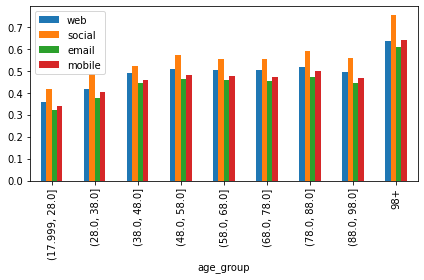

In [67]:
age_diff=np.arange(re_check_data['age'].min(), re_check_data['age'].max(), 10)
dash=pd.cut(re_check_data['age'], age_diff,include_lowest=True )
re_check_data['age_group']=dash
re_check_data.age_group.replace(np.nan, '98+', inplace=True)
new_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)])
new_sent=re_check_data.groupby('age_group')[['web','social','email','mobile']].sum()
new_completed=new_df1.groupby('age_group')[['web','social','email','mobile']].sum()
new_age=new_completed/new_sent
new_age.plot.bar()
plt.tight_layout()
plt.savefig('soage.png', dpi=300)

Age/channel wise conversion rate

From the plot it is clear that Social channel has highest number of conversion rate

Count total number of offers sent by each channel type

In [68]:
mcomp_df1=pd.DataFrame(re_check_data[['web','social','email','mobile']].sum())
mcomp_df1

,0
web,43132
social,32382
email,53987
mobile,48536


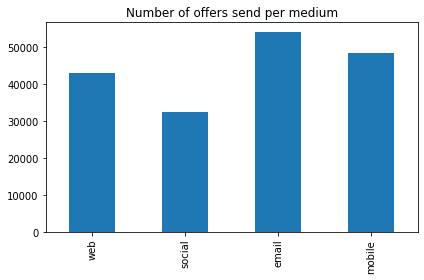

In [69]:
mcomp_df1.plot.bar(title="Number of offers send per medium", legend=None);
plt.tight_layout()
plt.savefig('sonum.png', dpi=300)

In [70]:
mcomp_df1v=pd.DataFrame(re_check_data[(re_check_data['viewed']==1)][['web','social','email','mobile']].sum())
mcomp_df1v

,0
web,31710
social,30648
email,41515
mobile,39581


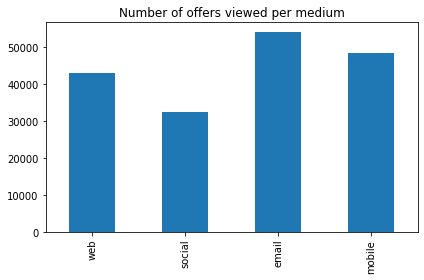

In [71]:
mcomp_df1.plot.bar(title="Number of offers viewed per medium", legend=None);
plt.tight_layout()
plt.savefig('vnum.png', dpi=300)

In [72]:
mcomp_df1c=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)][['web','social','email','mobile']].sum())
mcomp_df1c

,0
web,20686
social,17315
email,23499
mobile,22047


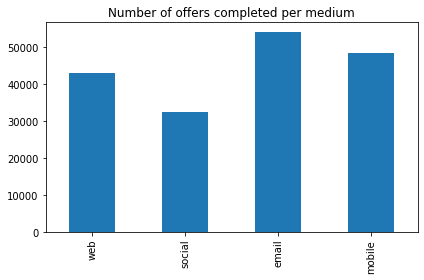

In [73]:
mcomp_df1.plot.bar(title="Number of offers completed per medium", legend=None);
plt.tight_layout()
plt.savefig('cnum.png', dpi=300)

In [74]:
m_compl=(mcomp_df1c/mcomp_df1v)*(mcomp_df1v/mcomp_df1)
m_compl

,0
web,0.479598
social,0.534711
email,0.435271
mobile,0.454240


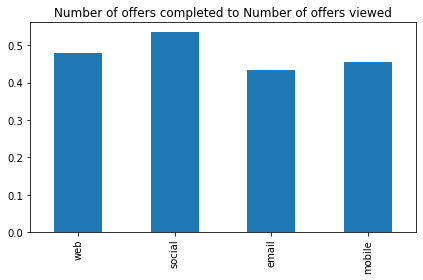

In [75]:
m_compl.plot.bar(title="Number of offers completed to Number of offers viewed", legend=None);
plt.tight_layout()
plt.savefig('cvnum.png', dpi=300)

From the plot it is clear that email has the highest number of offers send and Social has the lowest number of offers send 

Let's check if the same pattern is followed by Gender which was followed by age

In [76]:
def prep_data(new_df, g):
    '''This function returns the plot of comparision of different offer channels
       Args:
       new_df: DataFrame containing details from profile, portfolio and transaction
       g: gender(M/F/O)
    '''

    mcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1)& (new_df['gender']==g)][['web','social','email','mobile']].sum())
    mnview_df1=pd.DataFrame(new_df[(new_df['viewed']==0) & (new_df['completed']==1)& (new_df['gender']==g)][['web','social','email','mobile']].sum())
    msent_df1=pd.DataFrame(new_df[new_df['gender']==g][['web','social','email','mobile']].sum())
    mview_df1=pd.DataFrame(new_df[(new_df['viewed']==1)& (new_df['gender']=='M')][['web','social','email','mobile']].sum())


    mvis_df=pd.concat([msent_df1, mview_df1, mcomp_df1], axis=1)
    
    
    mvis_df.columns=['Sent','Viewed','Completed']
    mvs_ratio=mvis_df['Viewed']/mvis_df['Sent']
    
    
    mcv_ratio=mvis_df['Completed']/mvis_df['Viewed']
    mcv_ratio=mvs_ratio*mcv_ratio
    
    
    f= plt.subplots(figsize=(12,10))
    plt.subplot(221)
    ax1=plt.subplot(2, 2, 1)
    mvs_ratio.plot.bar(title='Offer Viewed vs Offer Sent');
    plt.tight_layout()
    plt.savefig('sosenm.png', dpi=300)

    ax2=plt.subplot(222 )
    mcv_ratio.plot.bar(title='Offer Completed vs Offer Viewed');
    plt.tight_layout()
    plt.savefig('socomm.png', dpi=300)
    plt.show()
    
   


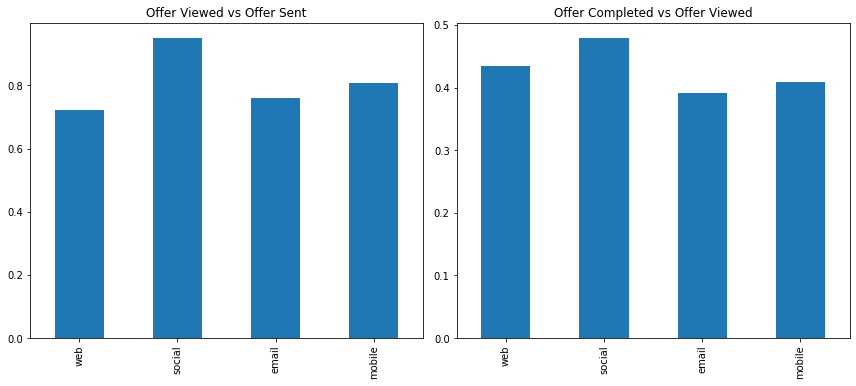

Offer Channel Comparison (Male)


In [77]:
prep_data(re_check_data,'M')
print("Offer Channel Comparison (Male)")

From the plot it is clear that Social channel has highest number of conversion rate

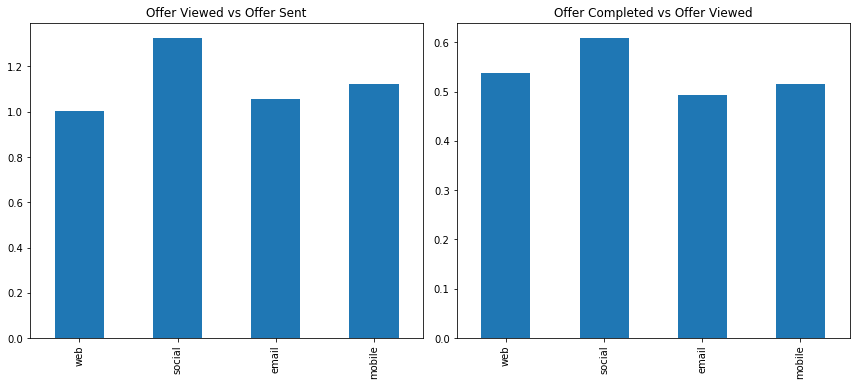

Offer Channel Comparison (Female)


In [78]:
prep_data(re_check_data,'F')
print("Offer Channel Comparison (Female)")

From the plot it is clear that Social channel has highest number of conversion rate

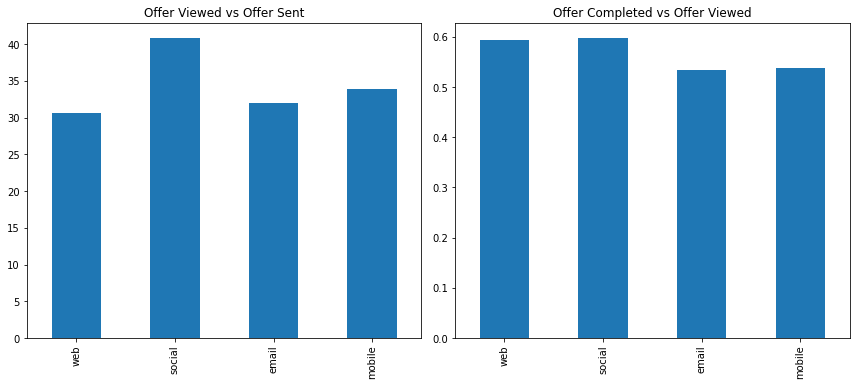

Offer Channel Comparison (Gender:'O')


In [79]:
prep_data(re_check_data,'O')
print("Offer Channel Comparison (Gender:'O')")

From the plot it is clear that Social channel has highest number of conversion rate

From all of the above plot it is clear that Social channel has highest conversion rate in every gender group and age group

Let's check if we can suggest Social as channel in any offer id

First count total offers sent with respect to offer id

In [80]:
off_sort=re_check_data.groupby('offer_id')['customer_id'].count().sort_values()
off_sort

offer_id
f19421c1d4aa40978ebb69ca19b0e20d    5316
2906b810c7d4411798c6938adc9daaa5    5337
3f207df678b143eea3cee63160fa8bed    5396
4d5c57ea9a6940dd891ad53e9dbe8da0    5399
2298d6c36e964ae4a3e7e9706d1fb8c2    5400
5a8bc65990b245e5a138643cd4eb9837    5409
fafdcd668e3743c1bb461111dcafc2a4    5412
9b98b8c7a33c4b65b9aebfe6a799e6d9    5421
ae264e3637204a6fb9bb56bc8210ddfd    5446
0b1e1539f2cc45b7b9fa7c272da2e1d7    5451
Name: customer_id, dtype: int64

Second, count the offer sent on the basis of highest conversion rate where user has viewed and completed the offer

In [81]:
on_sort=pd.DataFrame(re_check_data[(re_check_data['viewed']==1) & (re_check_data['completed']==1)]['offer_id'].value_counts())
on_sort.reset_index(level=0, inplace=True)
on_sort.rename(columns={'index':'offer_id','offer_id':'quantity'}, inplace=True)
on_sort

,offer_id,quantity
0,fafdcd668e3743c1bb461111dcafc2a4,4154
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4062
2,f19421c1d4aa40978ebb69ca19b0e20d,3481
3,ae264e3637204a6fb9bb56bc8210ddfd,2813
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2805
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,2397
6,2906b810c7d4411798c6938adc9daaa5,2335
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1452


In [82]:
on_sort=on_sort.merge(portfolio, right_on='offer_id', left_on='offer_id')
on_sort

,offer_id,quantity,reward,channels,difficulty,duration,offer_type
0,fafdcd668e3743c1bb461111dcafc2a4,4154,2,"[web, email, mobile, social]",10,10,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,4062,3,"[web, email, mobile, social]",7,7,discount
2,f19421c1d4aa40978ebb69ca19b0e20d,3481,5,"[web, email, mobile, social]",5,5,bogo
3,ae264e3637204a6fb9bb56bc8210ddfd,2813,10,"[email, mobile, social]",10,7,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2805,10,"[web, email, mobile, social]",10,5,bogo
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,2397,5,"[web, email, mobile]",5,7,bogo
6,2906b810c7d4411798c6938adc9daaa5,2335,2,"[web, email, mobile]",10,7,discount
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1452,5,"[web, email]",20,10,discount


In [83]:
offer_name=[]
for index in list(on_sort.index):
    offer_name.append(index+1)
on_sort['offer_name']=offer_name
place_sort=on_sort.copy()
place_sort.drop('offer_id', axis=1, inplace=True)
place_sort.set_index('offer_name',drop=True, )



,quantity,reward,channels,difficulty,duration,offer_type
offer_name,,,,,,
1,4154,2,"[web, email, mobile, social]",10,10,discount
2,4062,3,"[web, email, mobile, social]",7,7,discount
3,3481,5,"[web, email, mobile, social]",5,5,bogo
4,2813,10,"[email, mobile, social]",10,7,bogo
5,2805,10,"[web, email, mobile, social]",10,5,bogo
6,2397,5,"[web, email, mobile]",5,7,bogo
7,2335,2,"[web, email, mobile]",10,7,discount
8,1452,5,"[web, email]",20,10,discount


The lowest 3 offer ids don't have Social as the channel, so if we start sending these 3 offers via Social channel there might be some increase in total conversion for these offers.

Now, let's check the spending pattern with respect to gender

In [84]:
trans_pro=profile.merge(transcript_trans, left_on='customer_id', right_on='customer_id')
trans_pro

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day,event,time,days,amount,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,18,1,21.51,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,144,6,32.28,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,528,22,23.22,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,132,6,19.89,NaN
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,144,6,17.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123952,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,84,4,25.19,NaN
123953,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,96,4,21.53,NaN
123954,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,480,20,30.57,NaN
123955,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,486,20,19.47,NaN


Spending pattern on the basis of gender

Spending pattern per Transaction Distribution, Gender: F


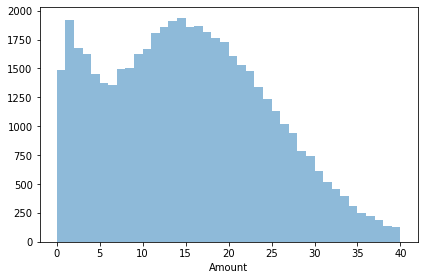

Spending pattern per Transaction Distribution, Gender: M


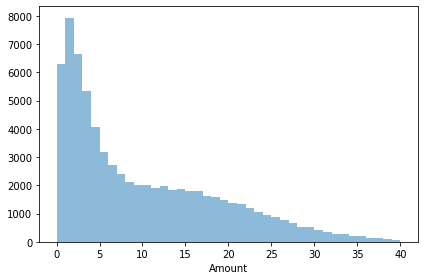

Spending pattern per Transaction Distribution, Gender: O


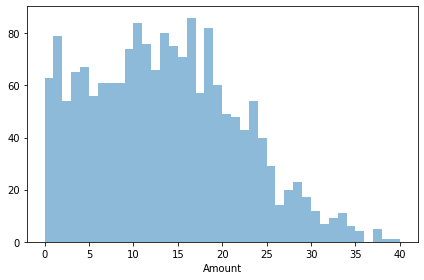

In [85]:
for gen in list(trans_pro['gender'].unique()):
    
    plt.hist(trans_pro[trans_pro['gender'] == gen]['amount'], range=(0, 40), alpha=0.5, bins=40, label='Male')
    
    print('Spending pattern per Transaction Distribution, Gender:',gen)
    
    plt.xlabel('Amount')
    plt.tight_layout()
    plt.savefig(gen+'.png', dpi=300)
    plt.show()

Above: Genderwise spending patter with Variable y limit

Below: Genderwise spending patter with rigid y limit

Spending pattern per Transaction Distribution, Gender: F


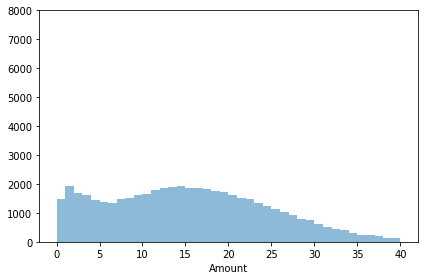

Spending pattern per Transaction Distribution, Gender: M


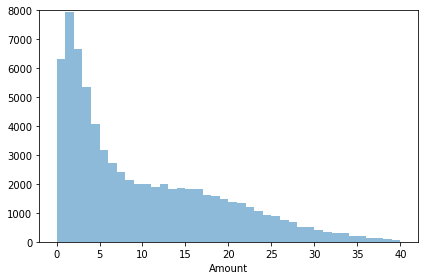

Spending pattern per Transaction Distribution, Gender: O


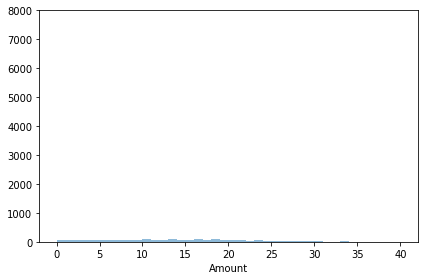

In [86]:
for gen in list(trans_pro['gender'].unique()):
    
    plt.hist(trans_pro[trans_pro['gender'] == gen]['amount'], range=(0, 40), alpha=0.5, bins=40, label='Male')
    
    print('Spending pattern per Transaction Distribution, Gender:',gen)
    
    plt.xlabel('Amount')
    plt.ylim(0,8000)
    plt.tight_layout()
    plt.savefig(gen+'.png', dpi=300)
    plt.show()

Gender wise spending pattern

In [87]:
gen_pro=trans_pro[['gender','amount']]
gen_pro=gen_pro.groupby('gender')['amount'].mean()
gen_pro

gender
F    17.490077
M    11.606600
O    14.798731
Name: amount, dtype: float64

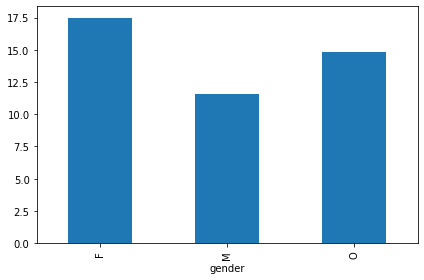

In [88]:
gen_pro.plot.bar()
plt.tight_layout()
plt.savefig('meaninc.png', dpi=300)

Gender wise Mean Spending 

#### Interpretation of above plots:

For male, the buying frquency is high however, the amount of purchase is lower than female, so to increase the amount, we need to find the mean value of all the purchases made by male population and then create offers around that amount
This would be the mean value of amount that is paid by male, we need to build more packages around it. That would increase the sales volume


For female customers we need to increase the frequency as the average speding amount is more than male
We need to create offer with lower validity (duration) and lower difficulties similar to two top viewed as well as complted offers. this will increase the frequency

Now, let's look into the details of how much amount we lost due to offers which are completed without being viewed.

In [89]:
age_diff=np.arange(trans_pro['age'].min()-1, re_check_data['age'].max()+1,12)
dash=pd.cut(trans_pro['age'], age_diff)
trans_pro['age_group']=dash
    

Spending pattern per Transaction Districution: Age: (17, 29]


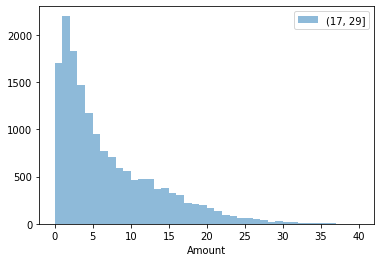

Spending pattern per Transaction Districution: Age: (29, 41]


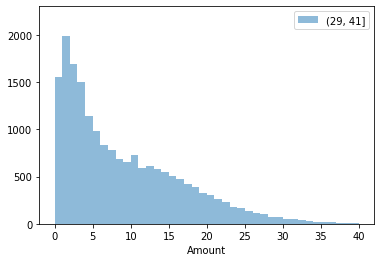

Spending pattern per Transaction Districution: Age: (41, 53]


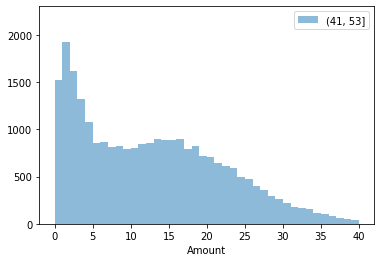

Spending pattern per Transaction Districution: Age: (53, 65]


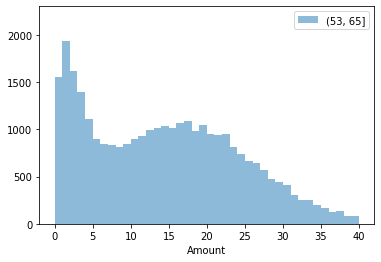

Spending pattern per Transaction Districution: Age: (65, 77]


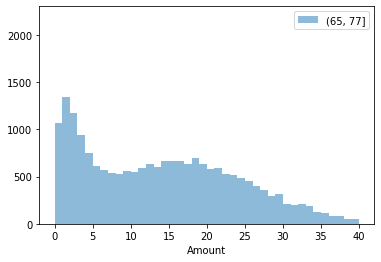

Spending pattern per Transaction Districution: Age: (77, 89]


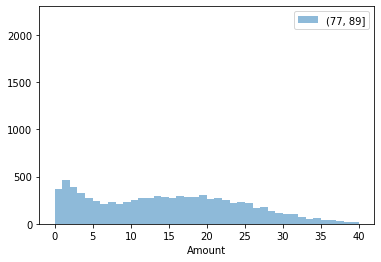

Spending pattern per Transaction Districution: Age: (89, 101]


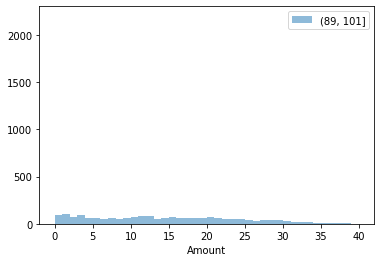

<Figure size 432x288 with 0 Axes>

In [90]:
for age in list(trans_pro['age_group'].unique().sort_values()):
   
    plt.hist(trans_pro[trans_pro['age_group'] == age]['amount'], range=(0, 40), alpha=0.5, bins=40, label=age)
    plt.legend(loc='upper right')

    print('Spending pattern per Transaction Districution: Age:',age)


    plt.xlabel('Amount')
    
    age=str(age)
    plt.ylim(0,2300)
    plt.show()
    plt.tight_layout()
    plt.savefig(age +'y.png', dpi=300)

    

Above: Agewise spending patter with rigid y limit
    
Below: Agewise spending patter with Variable y limit


Spending pattern per Transaction Districution: Age: (17, 29]


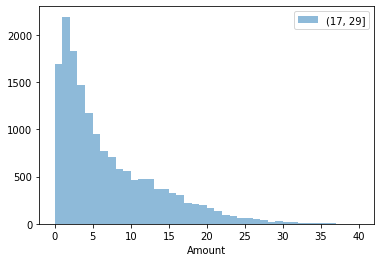

Spending pattern per Transaction Districution: Age: (29, 41]


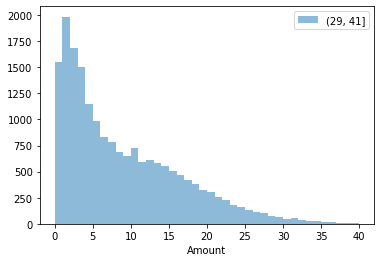

Spending pattern per Transaction Districution: Age: (41, 53]


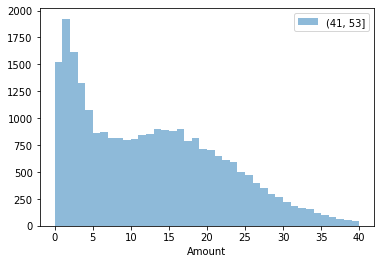

Spending pattern per Transaction Districution: Age: (53, 65]


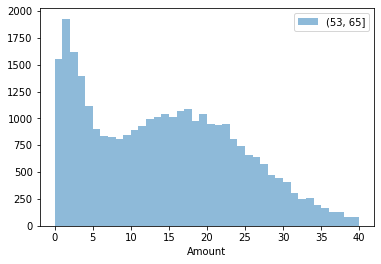

Spending pattern per Transaction Districution: Age: (65, 77]


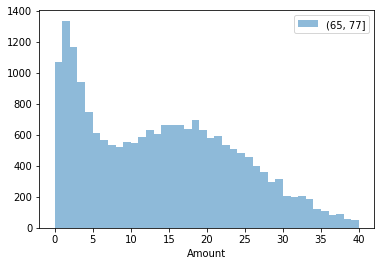

Spending pattern per Transaction Districution: Age: (77, 89]


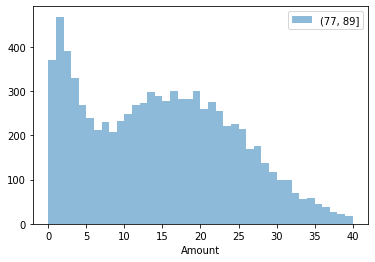

Spending pattern per Transaction Districution: Age: (89, 101]


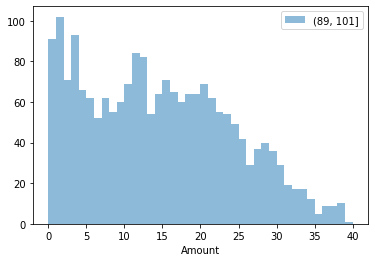

<Figure size 432x288 with 0 Axes>

In [91]:
for age in list(trans_pro['age_group'].unique().sort_values()):
   
    plt.hist(trans_pro[trans_pro['age_group'] == age]['amount'], range=(0, 40), alpha=0.5, bins=40, label=age)
    plt.legend(loc='upper right')

    print('Spending pattern per Transaction Districution: Age:',age)


    plt.xlabel('Amount')
    
    plt.show()
    age=str(age)
    plt.tight_layout()
    plt.savefig(age +'.png', dpi=300)


Age wise spending pattern distribution

### Total Loss

In [92]:
loss_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==0) & (re_check_data['completed']==1)])
loss_df1.reset_index(drop=True, inplace=True)
loss_df1

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,bogo,discount,...,mobile,email,gender,age,income,join_year,join_month,join_day,amount,age_group
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,1,1,M,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]"
1,005500a7188546ff8a767329a2f7c76a,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,...,1,1,M,56,47000.0,2017,12,9,20.36,"(48.0, 58.0]"
2,00715b6e55c3431cb56ff7307eb19675,1,0,1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,...,1,1,F,58,119000.0,2017,12,7,375.12,"(48.0, 58.0]"
3,00840a2ca5d2408e982d56544dc14ffd,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,...,1,1,M,26,61000.0,2014,12,21,62.93,"(17.999, 28.0]"
4,0099bf30e4cb4265875266eb3eb25eab,1,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,...,0,1,M,61,66000.0,2018,2,14,105.83,"(58.0, 68.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,f97af6e7c31b4e16b078c3224b78f6a4,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,...,1,1,F,55,72000.0,2017,5,24,134.22,"(48.0, 58.0]"
4439,fd66b15232a6437c86ad584849360e6f,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,...,1,1,F,52,85000.0,2017,6,6,48.56,"(48.0, 58.0]"
4440,ffac285a64714aca8efd8d61a5606e84,1,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,...,1,1,M,28,36000.0,2017,10,22,9.63,"(17.999, 28.0]"
4441,55d77afdd5fd481aafc282f23516d7c0,1,0,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,1,1,F,49,88000.0,2016,11,20,127.35,"(48.0, 58.0]"


In [93]:
print ('Total Loss:',loss_df1.reward.sum())

Total Loss: 20544


To find which offer causes the most loss

In [94]:
offer_loss=loss_df1.groupby('offer_id')['reward'].sum().sort_values(ascending=False)
offer_loss

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7460
9b98b8c7a33c4b65b9aebfe6a799e6d9    6150
ae264e3637204a6fb9bb56bc8210ddfd    3330
2906b810c7d4411798c6938adc9daaa5    2096
4d5c57ea9a6940dd891ad53e9dbe8da0     600
f19421c1d4aa40978ebb69ca19b0e20d     405
2298d6c36e964ae4a3e7e9706d1fb8c2     315
fafdcd668e3743c1bb461111dcafc2a4     188
Name: reward, dtype: int64

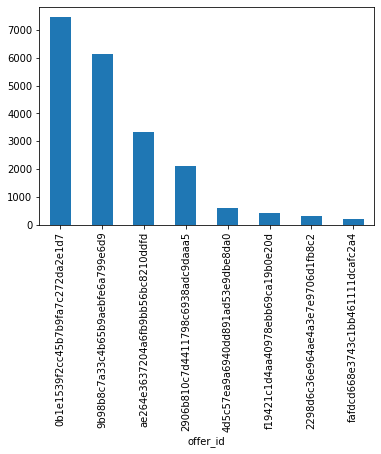

In [95]:
offer_loss.plot.bar();

plt.savefig('offer_id loss.png', dpi=300)


Graphical representation : Offer wise loss

In [96]:
re_check_data.groupby('age_group')['gender'].value_counts()

age_group       gender
(17.999, 28.0]  M         3862
                F         1506
                O           53
(28.0, 38.0]    M         3626
                F         1778
                O           54
(38.0, 48.0]    M         4922
                F         2747
                O          132
(48.0, 58.0]    M         6886
                F         5628
                O          195
(58.0, 68.0]    M         6119
                F         5037
                O          158
(68.0, 78.0]    M         3612
                F         3164
                O           90
(78.0, 88.0]    F         1728
                M         1473
                O           36
(88.0, 98.0]    F          660
                M          428
                O           16
98+             F           64
                M           10
                O            3
Name: gender, dtype: int64

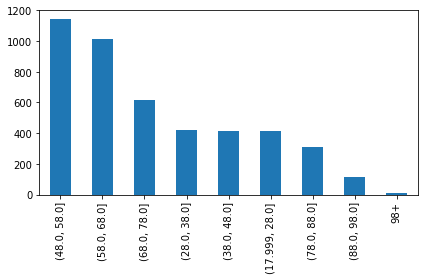

In [97]:
new_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==0) & (re_check_data['completed']==1)])
new_age=new_df1.age_group.value_counts()
new_age.plot.bar()
plt.tight_layout()
plt.savefig('age_loss number.png', dpi=300)

Age wise graphical representation of customers who are not viewing the offer but completing it

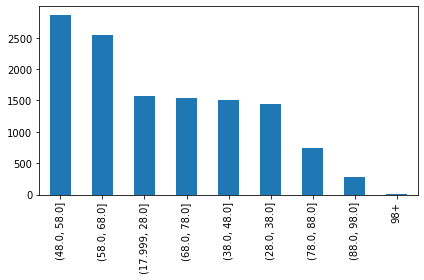

In [98]:
new_df1=pd.DataFrame(re_check_data[(re_check_data['viewed']==0)])
#new_sent=new_df1.groupby('age_group')['gender'].value_counts()
#new_completed=new_df1.groupby('age_group')['gender'].value_counts()
new_age=new_df1.age_group.value_counts()
new_age.plot.bar()
plt.tight_layout()
plt.savefig('age_no interaction.png', dpi=300)

Age wise graphical representation of people who have no interactions with the offers sent

In [99]:
new_df1.groupby('age_group')['gender'].value_counts()

age_group       gender
(17.999, 28.0]  M         1141
                F          413
                O           15
(28.0, 38.0]    M          978
                F          450
                O           11
(38.0, 48.0]    M         1043
                F          447
                O           18
(48.0, 58.0]    M         1568
                F         1267
                O           22
(58.0, 68.0]    M         1414
                F         1098
                O           25
(68.0, 78.0]    M          797
                F          734
                O            7
(78.0, 88.0]    F          394
                M          336
                O           11
(88.0, 98.0]    F          162
                M          110
98+             F            9
                M            2
Name: gender, dtype: int64

In [100]:
re_check_data.groupby('age_group')['gender'].value_counts()

age_group       gender
(17.999, 28.0]  M         3862
                F         1506
                O           53
(28.0, 38.0]    M         3626
                F         1778
                O           54
(38.0, 48.0]    M         4922
                F         2747
                O          132
(48.0, 58.0]    M         6886
                F         5628
                O          195
(58.0, 68.0]    M         6119
                F         5037
                O          158
(68.0, 78.0]    M         3612
                F         3164
                O           90
(78.0, 88.0]    F         1728
                M         1473
                O           36
(88.0, 98.0]    F          660
                M          428
                O           16
98+             F           64
                M           10
                O            3
Name: gender, dtype: int64

In [101]:
new_df1=dummies(re_check_data, 'gender')
new_df1

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,bogo,discount,...,age,income,join_year,join_month,join_day,amount,age_group,F,M,O
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,66,59000.0,2017,10,1,53.95,"(58.0, 68.0]",1,0,0
53983,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,68,38000.0,2013,12,15,44.32,"(58.0, 68.0]",0,1,0
53984,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,61,44000.0,2016,1,8,182.39,"(58.0, 68.0]",0,1,0
53985,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,82,84000.0,2018,4,18,34.53,"(78.0, 88.0]",1,0,0


In [102]:
new_df2=pd.DataFrame(new_df1[(new_df1['viewed']==0) & (new_df1['completed']==1)])

In [103]:
new_df1

,customer_id,received,viewed,completed,offer_id,reward,difficulty,duration,bogo,discount,...,age,income,join_year,join_month,join_day,amount,age_group,F,M,O
0,0009655768c64bdeb2e877511632db8f,1,0,1,2906b810c7d4411798c6938adc9daaa5,2,10,7,0,1,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
1,0009655768c64bdeb2e877511632db8f,1,1,0,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
2,0009655768c64bdeb2e877511632db8f,1,1,0,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
3,0009655768c64bdeb2e877511632db8f,1,1,1,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
4,0009655768c64bdeb2e877511632db8f,1,1,1,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,...,33,72000.0,2017,4,21,127.60,"(28.0, 38.0]",0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,86114b8f1921463f8991c68520ccf5c4,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,66,59000.0,2017,10,1,53.95,"(58.0, 68.0]",1,0,0
53983,930305f046fa4f218d2539fb99baefb9,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,68,38000.0,2013,12,15,44.32,"(58.0, 68.0]",0,1,0
53984,948ec827ac334c8782a1da99a2d6a39b,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,61,44000.0,2016,1,8,182.39,"(58.0, 68.0]",0,1,0
53985,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,...,82,84000.0,2018,4,18,34.53,"(78.0, 88.0]",1,0,0


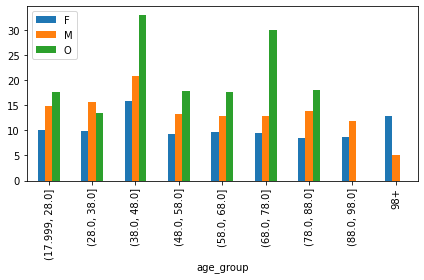

In [104]:
new_sent=new_df2.groupby('age_group')[['F','M','O']].sum()
new_completed=new_df1.groupby('age_group')[['F','M','O']].sum()
new_age=new_completed/new_sent
new_age.plot.bar()
plt.tight_layout()
plt.savefig('gender_loss interaction.png', dpi=300)

age/gender wise graphical representation of customers who are not viewing the offer but completing it

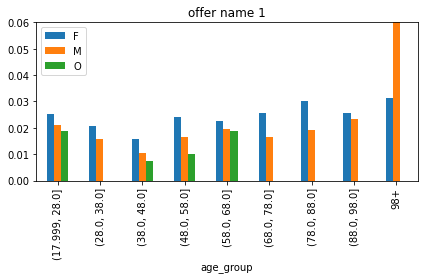

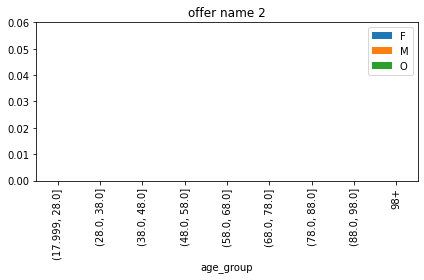

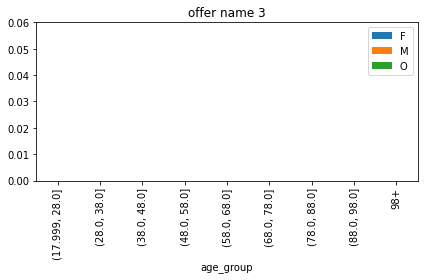

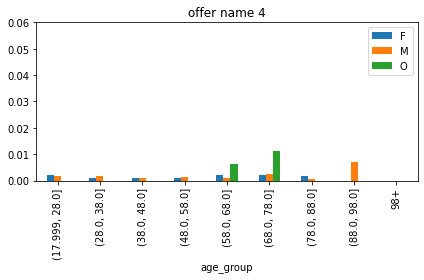

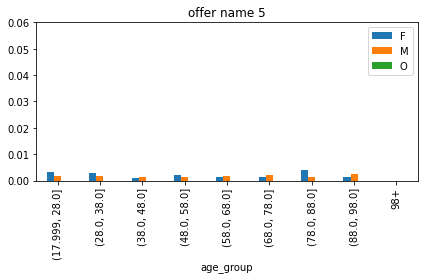

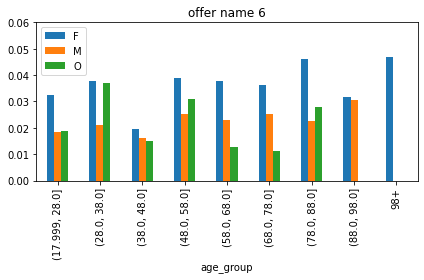

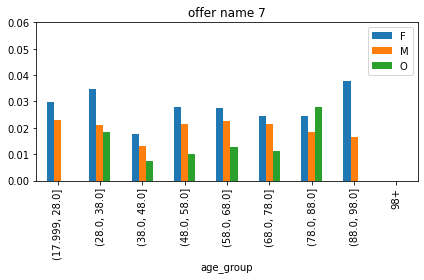

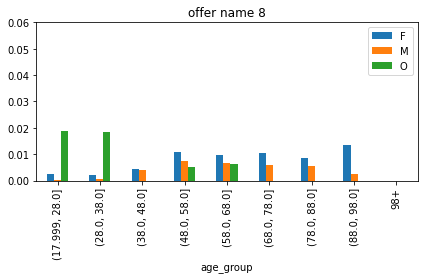

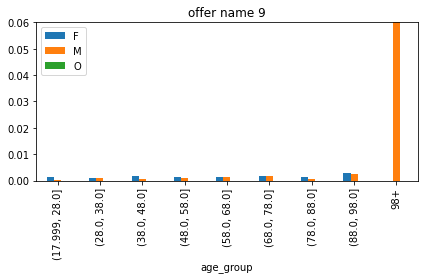

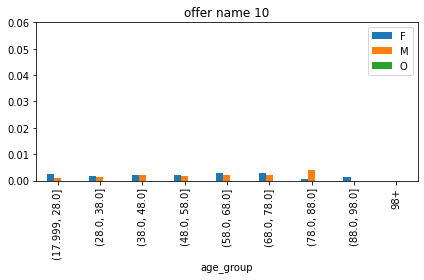

In [105]:
i=1
for num in list(new_df1.offer_id.unique()):
    
    
    new_df2=new_df1[(new_df1['offer_id']==num) & (new_df1['viewed']==0) & (new_df1['completed']==1)]
    new_sent=new_df1.groupby('age_group')[['F','M','O']].sum()
    new_completed=new_df2.groupby('age_group')[['F','M','O']].sum()
    new_age=new_completed/new_sent
    new_age.plot.bar(title=num)
    plt.ylim(0,0.06)
    plt.tight_layout()
    name='offer name '+str(i)
    plt.title(name)
    plt.savefig(num+'ofgenagloss.png', dpi=300)
    i+=1

    

offer wise graphical representation of the customers who are completing the offer without viewing with rigid y limit

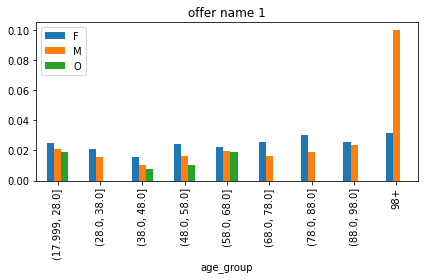

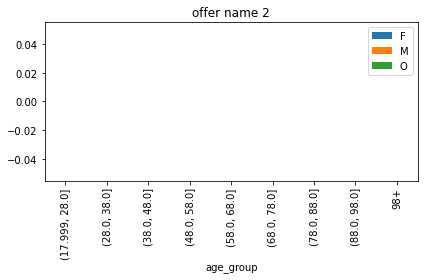

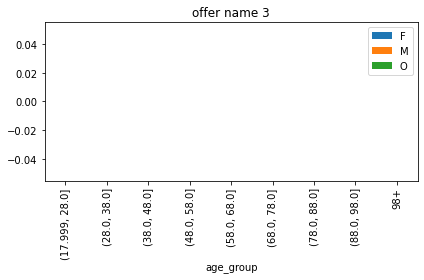

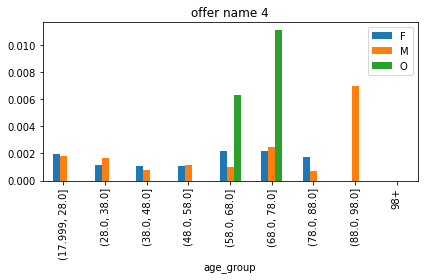

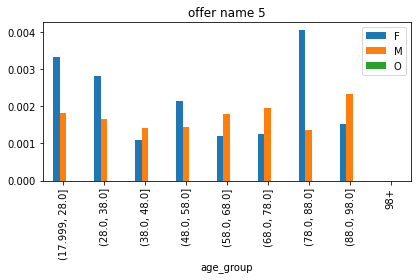

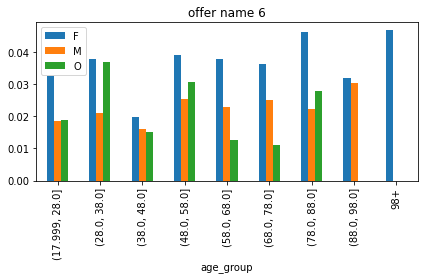

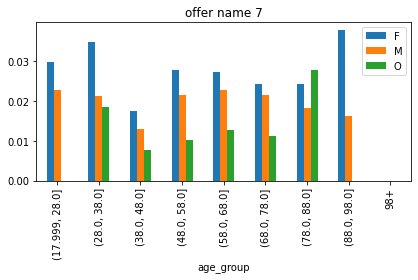

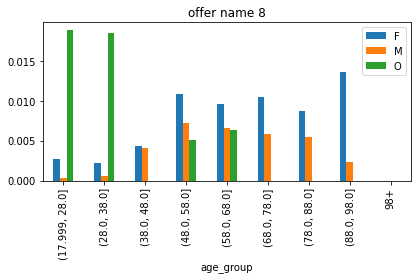

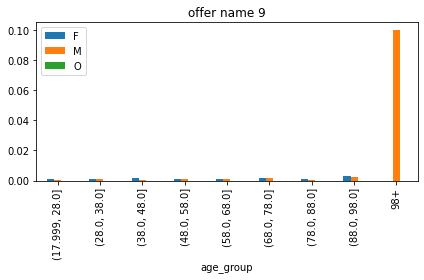

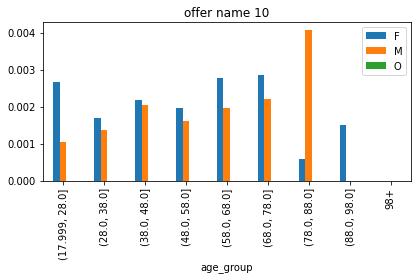

In [106]:
i=1
for num in list(new_df1.offer_id.unique()):
    
    
    new_df2=new_df1[(new_df1['offer_id']==num) & (new_df1['viewed']==0) & (new_df1['completed']==1)]
    new_sent=new_df1.groupby('age_group')[['F','M','O']].sum()
    new_completed=new_df2.groupby('age_group')[['F','M','O']].sum()
    new_age=new_completed/new_sent
    new_age.plot.bar(title=num)
    name='offer name '+str(i)
    plt.title(name)
    plt.tight_layout()
    plt.savefig(num+'ofgenaglossy.png', dpi=300)
    i+=1

offer wise graphical representation of the customers who are completing the offer without viewing with variable y limit

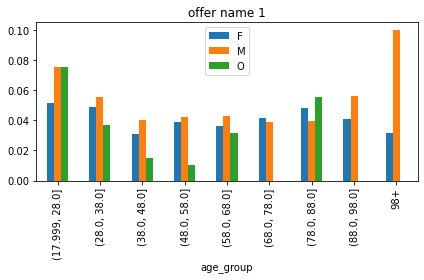

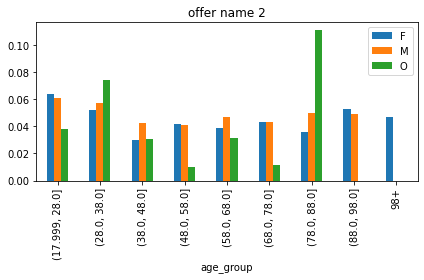

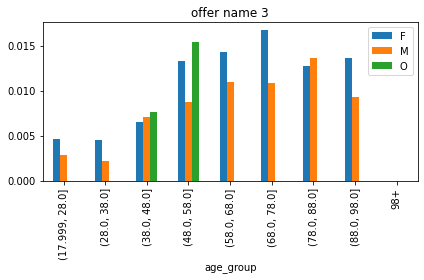

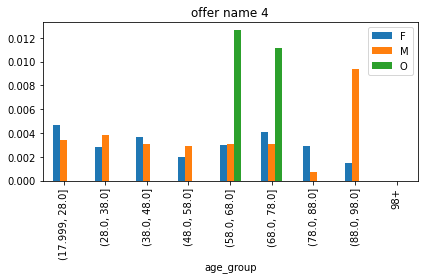

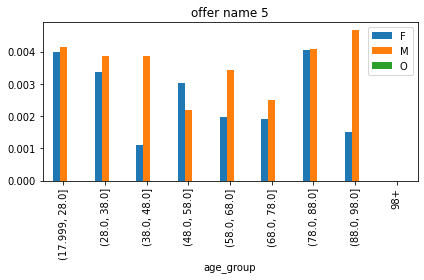

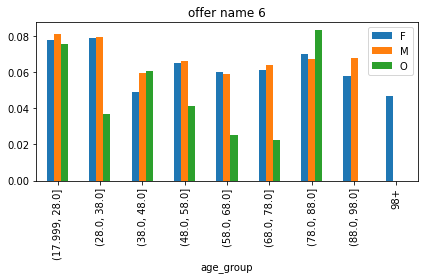

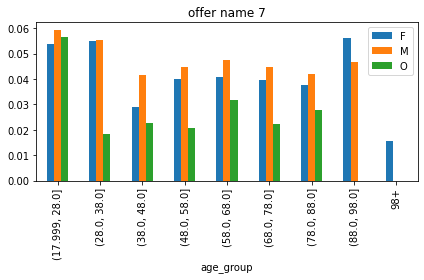

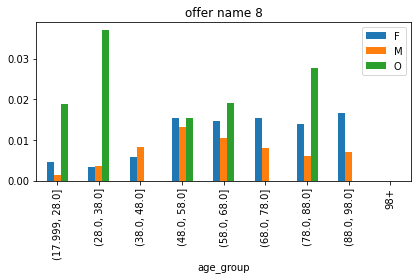

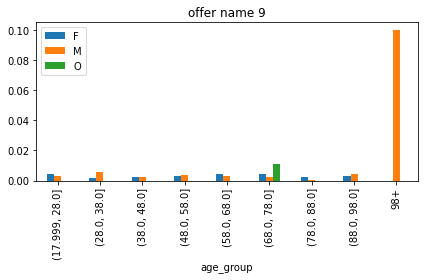

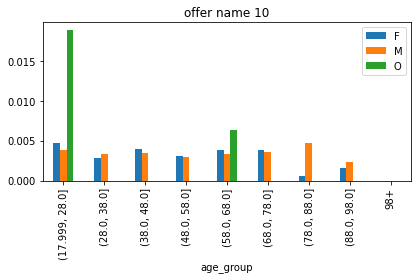

In [107]:
i=1
for num in list(new_df1.offer_id.unique()):
    new_df2=new_df1[(new_df1['offer_id']==num) & (new_df1['viewed']==0)]
    new_sent=new_df1.groupby('age_group')[['F','M','O']].sum()
    new_completed=new_df2.groupby('age_group')[['F','M','O']].sum()
    new_age=new_completed/new_sent
    new_age.plot.bar(title=num)
    name='offer name '+str(i)
    plt.title(name)
    plt.tight_layout()
    plt.savefig(num+'ofgenagnoint.png', dpi=300)
    i+=1

Offer wise graphical representation of customers showing no interaction with offers sent age/gender wise with variable y limit

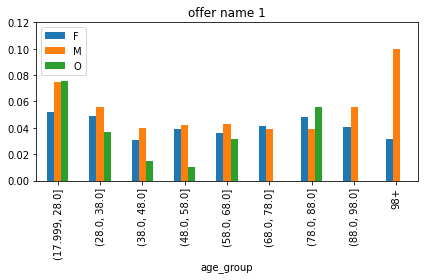

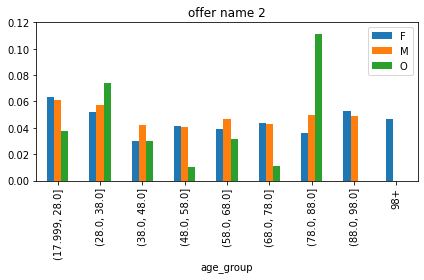

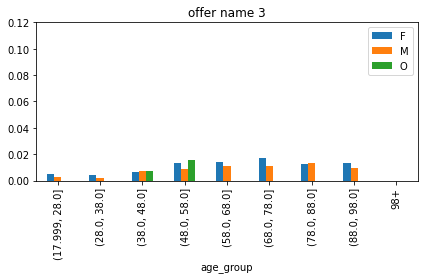

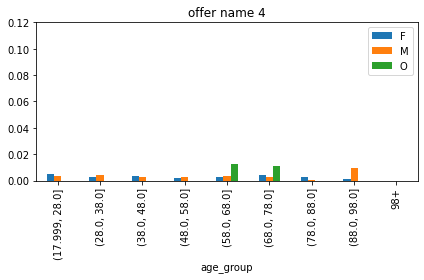

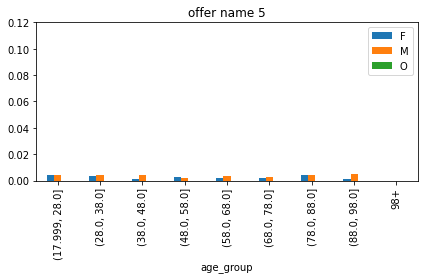

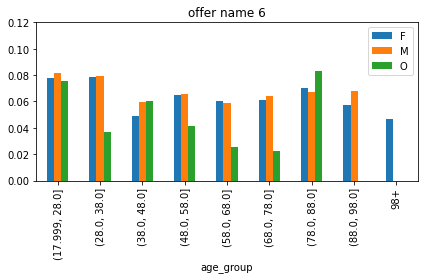

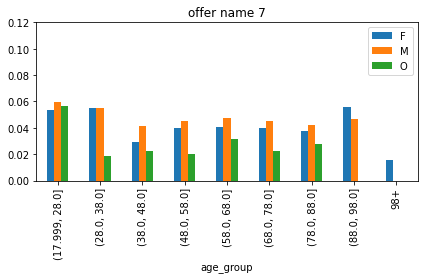

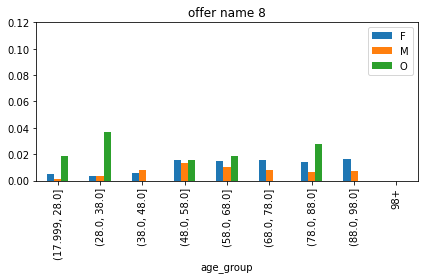

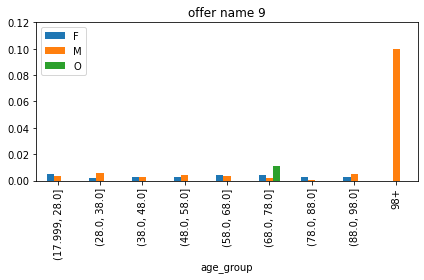

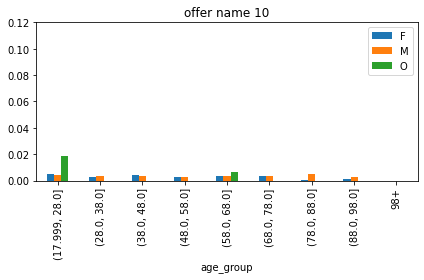

In [108]:
i=1
for num in list(new_df1.offer_id.unique()):
    new_df2=new_df1[(new_df1['offer_id']==num) & (new_df1['viewed']==0)]
    new_sent=new_df1.groupby('age_group')[['F','M','O']].sum()
    new_completed=new_df2.groupby('age_group')[['F','M','O']].sum()
    new_age=new_completed/new_sent
    new_age.plot.bar(title=num)
    plt.ylim(0,0.12)
    name='offer name '+str(i)
    plt.title(name)
    plt.tight_layout()
    plt.savefig(num+'ofgenagnointy.png', dpi=300)
    i=i+1

Offer wise graphical representation of customers showing no interaction with offers sent age/gender wise with rigid y limit

## Data Preprocessing

#### Checkpoint

In [109]:
stat=re_check_data.copy()

In [110]:
re_check_data=stat.copy()

One hot encoding of columns for modeling

Gender

In [111]:
re_check_data=dummies(re_check_data, 'gender')

In [112]:
re_check_data=dummies(re_check_data, 'offer_id')

In [113]:
income_diff=np.linspace(re_check_data['income'].min(), re_check_data['income'].max(), num=5)
dash=pd.cut(re_check_data['income'], income_diff,include_lowest=True)
dash.unique().sort_values()
re_check_data['income_group']=dash
re_check_data['income_group'].unique()

[(52500.0, 75000.0], (29999.999, 52500.0], (97500.0, 120000.0], (75000.0, 97500.0]]
Categories (4, interval[float64]): [(29999.999, 52500.0] < (52500.0, 75000.0] < (75000.0, 97500.0] < (97500.0, 120000.0]]

In [114]:
re_check_data=dummies(re_check_data, 'income_group')
re_check_data=dummies(re_check_data, 'age_group')
re_check_data.drop('income', axis=1, inplace=True)
re_check_data.drop('age', axis=1, inplace=True)

In [115]:
re_check_data

,customer_id,received,viewed,completed,reward,difficulty,duration,bogo,discount,informational,...,"(97500.0, 120000.0]","(17.999, 28.0]","(28.0, 38.0]","(38.0, 48.0]","(48.0, 58.0]","(58.0, 68.0]","(68.0, 78.0]","(78.0, 88.0]","(88.0, 98.0]",98+
0,0009655768c64bdeb2e877511632db8f,1,0,1,2,10,7,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0009655768c64bdeb2e877511632db8f,1,1,0,0,0,4,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0009655768c64bdeb2e877511632db8f,1,1,0,0,0,3,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,1,1,1,5,5,5,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0009655768c64bdeb2e877511632db8f,1,1,1,2,10,10,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,86114b8f1921463f8991c68520ccf5c4,1,1,1,10,10,7,1,0,0,...,0,0,0,0,0,1,0,0,0,0
53983,930305f046fa4f218d2539fb99baefb9,1,1,0,10,10,7,1,0,0,...,0,0,0,0,0,1,0,0,0,0
53984,948ec827ac334c8782a1da99a2d6a39b,1,1,1,10,10,7,1,0,0,...,0,0,0,0,0,1,0,0,0,0
53985,d957b9bd21fd4cacb39aab4b2834704b,1,1,0,10,10,7,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [116]:
re_check_data['success']=(re_check_data.viewed==1)&(re_check_data.completed==1)

In [117]:
re_check_data['success']=re_check_data['success'].astype(int)

In [118]:
re_check_data.columns=['customer_id','received','viewed', 'completed','reward','difficulty','duration','bogo','discount','informational','social','web','mobile', 'email','year', 'month', 'day','amount','F','M','O','offer1', 'offer2','offer3', 'offer4','offer5', 'offer6','offer7', 'offer8', 'offer9', 'offer10','income1','income2','income3','income4','age1','age2','age3','age4','age5','age6','age7','age8','age9', 'success']

In [119]:
re_check_data.columns

Index(['customer_id', 'received', 'viewed', 'completed', 'reward',
       'difficulty', 'duration', 'bogo', 'discount', 'informational', 'social',
       'web', 'mobile', 'email', 'year', 'month', 'day', 'amount', 'F', 'M',
       'O', 'offer1', 'offer2', 'offer3', 'offer4', 'offer5', 'offer6',
       'offer7', 'offer8', 'offer9', 'offer10', 'income1', 'income2',
       'income3', 'income4', 'age1', 'age2', 'age3', 'age4', 'age5', 'age6',
       'age7', 'age8', 'age9', 'success'],
      dtype='object')

Divide re_check_data dateset into bogo and discount dataset

In [120]:
bogo=re_check_data[(re_check_data.bogo==1)]
bogo.reset_index(drop=True, inplace=True)
discount=re_check_data[(re_check_data.discount==1)]
discount.reset_index(drop=True, inplace=True)

#### Checkpoint

In [121]:
re_check_data.to_csv('re_check_data', index=False)

In [122]:
re_check_data=pd.read_csv('re_check_data')

# Data Modeling

After trying many models XGBoost gives better accuracy. Since all the models are consumes a lots of processing time. I am going with XGBoost only

In [123]:
def model_yield(model, X,y): 
    '''
    
      Inputs:
       - model, X & y dataframe 
       - Splits X and y dataframe to train and test sets, performs feature scaling on both datasets.
       - model: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: X training set
       - y_train: review_scores_rating training set
       - X_test: X testing set
       - y_test: review_scores_rating testing set
       
       Splits the data into train, test and split, perform scaling using StandardScaler and then fit model
       score model with classification report and confusion matrix
       
    '''
    pred = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    eval_set=[(X_val,y_val)]
        
   
    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    #scale test data
    X_test=scaler.transform(X_test)
    
    #Fit the model to the training data and get training time
   
    model=model.fit(X_train, y_train, eval_metric="mlogloss", verbose=True)
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train) 
    
    #add training accuracy to pred
    pred['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to pred
    pred['testing_score']=model.score(X_test,y_test)
                                      
    
    print("MSE_train: %.4f" % mean_squared_error(y_train,pred_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,pred_test))
    print("Training accuracy:%.4f" % pred['training_score'])
    print("Test accuracy:%.4f" % pred['testing_score'])
    print(classification_report(y_test, pred_test,digits=4))
    
    cm = confusion_matrix(y_test, pred_test)

    fig, ax= plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    
    # features importance 
    plot_importance(model)


We are going to use the model onto Existing customer and new customer scenario with three database namely bogo, discount and re_check_data

#### For Existing Customers

 BOGO Dataset

[00:53:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.1122
MSE_test: 0.1459
Training accuracy:0.8878
Test accuracy:0.8541
              precision    recall  f1-score   support

           0     0.8631    0.8168    0.8393      2014
           1     0.8470    0.8867    0.8664      2303

    accuracy                         0.8541      4317
   macro avg     0.8550    0.8517    0.8528      4317
weighted avg     0.8545    0.8541    0.8537      4317



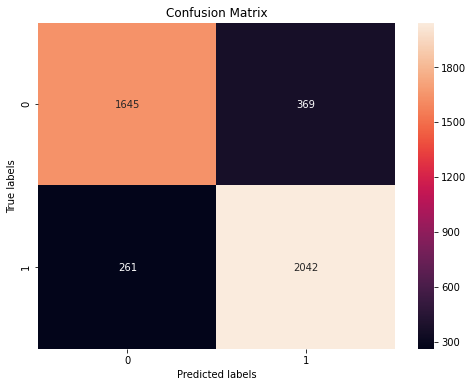

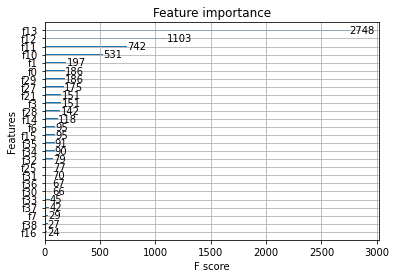

In [124]:
X=bogo.drop(['success','customer_id', 'received', 'completed','bogo'], axis=1)
y=bogo.success

model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

 Discount Dataset

[00:54:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.0775
MSE_test: 0.0949
Training accuracy:0.9225
Test accuracy:0.9051
              precision    recall  f1-score   support

           0     0.9221    0.8638    0.8920      1960
           1     0.8925    0.9394    0.9154      2360

    accuracy                         0.9051      4320
   macro avg     0.9073    0.9016    0.9037      4320
weighted avg     0.9059    0.9051    0.9048      4320



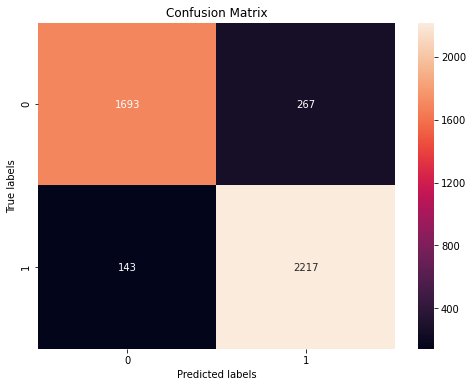

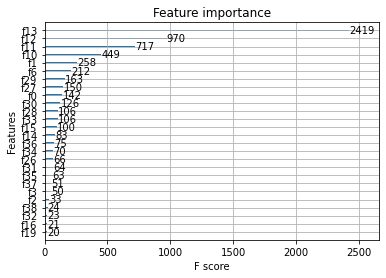

In [125]:
X=discount.drop(['success','customer_id', 'received', 'completed', 'discount'], axis=1)
y=discount.success


model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

Whole dataset

[04:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.0886
MSE_test: 0.0937
Training accuracy:0.9114
Test accuracy:0.9063
              precision    recall  f1-score   support

           0     0.9408    0.8907    0.9150      6118
           1     0.8664    0.9267    0.8955      4680

    accuracy                         0.9063     10798
   macro avg     0.9036    0.9087    0.9053     10798
weighted avg     0.9085    0.9063    0.9066     10798



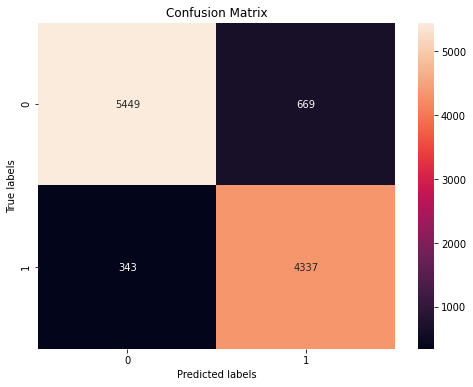

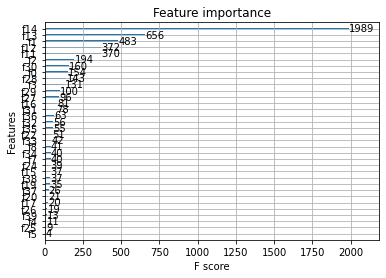

In [146]:
X=re_check_data.drop(['success','customer_id', 'received', 'completed'], axis=1)
y=re_check_data.success


model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

#### For new Customers

[00:54:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.2241
MSE_test: 0.3236
Training accuracy:0.7759
Test accuracy:0.6764
              precision    recall  f1-score   support

           0     0.6553    0.6465    0.6508      2014
           1     0.6944    0.7026    0.6985      2303

    accuracy                         0.6764      4317
   macro avg     0.6748    0.6745    0.6747      4317
weighted avg     0.6762    0.6764    0.6762      4317



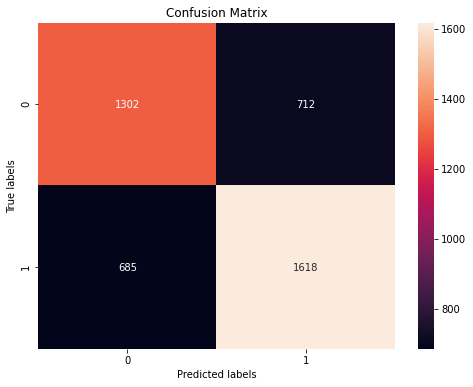

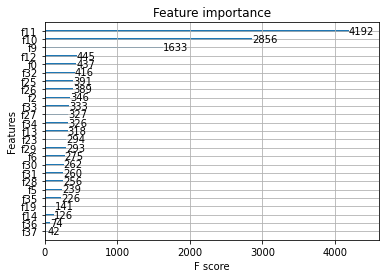

In [127]:
#BOGO Dataset
X=bogo.drop(['success','customer_id', 'received', 'completed','viewed', 'amount','bogo'], axis=1)
y=bogo.success

#Initialize the model - baseline is DT model, bogo_1 model is RF model
model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

[00:54:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.2005
MSE_test: 0.2706
Training accuracy:0.7995
Test accuracy:0.7294
              precision    recall  f1-score   support

           0     0.7025    0.7000    0.7013      1960
           1     0.7516    0.7538    0.7527      2360

    accuracy                         0.7294      4320
   macro avg     0.7270    0.7269    0.7270      4320
weighted avg     0.7293    0.7294    0.7294      4320



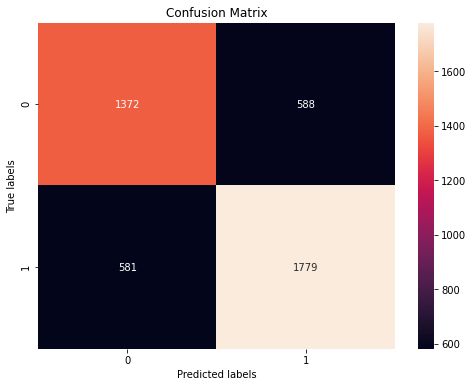

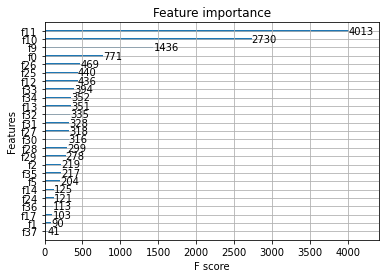

In [128]:
#Discount Dataset
X=discount.drop(['success','customer_id', 'received', 'completed','viewed', 'amount','discount'], axis=1)
y=discount.success

#Initialize the model - baseline is DT model, bogo_1 model is RF model
model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

[00:54:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MSE_train: 0.2001
MSE_test: 0.2275
Training accuracy:0.7999
Test accuracy:0.7725
              precision    recall  f1-score   support

           0     0.7992    0.7993    0.7992      6118
           1     0.7376    0.7374    0.7375      4680

    accuracy                         0.7725     10798
   macro avg     0.7684    0.7683    0.7683     10798
weighted avg     0.7725    0.7725    0.7725     10798



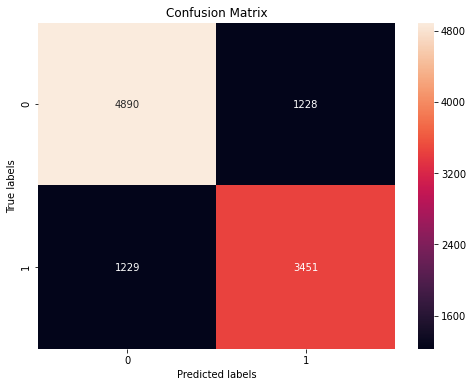

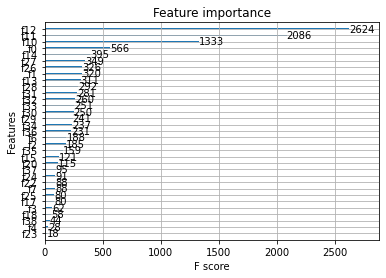

In [129]:
#Whole Dataset
X=re_check_data.drop(['success','customer_id', 'received', 'completed','viewed', 'amount'], axis=1)
y=re_check_data.success

#Initialize the model - baseline is DT model, bogo_1 model is RF model
model = XGBClassifier(learning_rate = 0.1,num_class=4,max_depth = 7,min_child_weight = 5,objective = 'multi:softmax',seed = 42,gamma = 0.1,silent = True)
model_yield(model, X,y)

The lowering of accuracy was obvious as very less information present about the new customer hence low accuracy.

### Refinement

Imporvement in predictions using gridsearch

In [130]:
def XGBClassifierGrid(X_train, y_train):
    '''
    Input: X_train, y_train
    Output: model
    
    Provide gridsearch over XGBClassifier put best parameters in model for further use
    '''
    
    
    clf= XGBClassifier(num_class=4, objective = 'multi:softmax')
    param_grid = {
        'n_estimators': [25, 50, 100, 200, 500],
        'max_depth': [3, 5, 8 ,10],
        'gamma': [0.01, 0.1, 0.5, 1, 1.5, 2, 6],
        'subsample':[0.5,  0.8,  1.0],
        'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
        'learning_rate': [0.01, 0.05, 0.1, 0.2], 
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 10.0],
        'silent': [True, False]
    }
    fit_params = {
        "verbose":True,
    }
    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                           scoring='f1_weighted',  random_state=42)
    print("Randomized search..")
    rs_clf.fit(X_train, y_train)
    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_
    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))
    model = rs_clf.best_estimator_
    
    return model
    

#### New customers

Randomized search..
[02:02:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:02:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:02:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[02:04:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:05:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:05:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:06:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:07:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:07:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:08:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:08:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:08:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:09:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:09:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:09:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

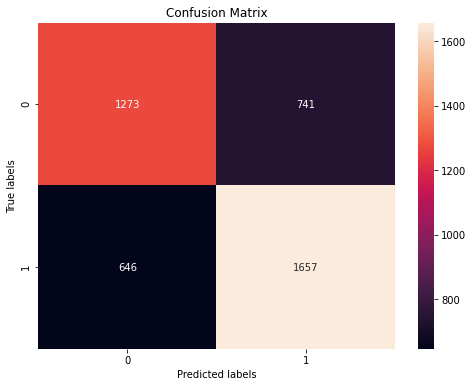

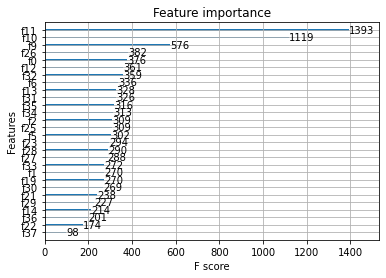

In [137]:
#define discount dataset XGBoost for new customers
X=bogo.drop(['success','customer_id', 'received','viewed', 'completed', 'amount','bogo'], axis=1)
y=bogo.success

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)


Randomized search..
[03:33:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:33:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[03:35:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:36:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:36:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:38:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:38:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:38:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:39:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:39:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:39:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:40:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:40:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:40:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

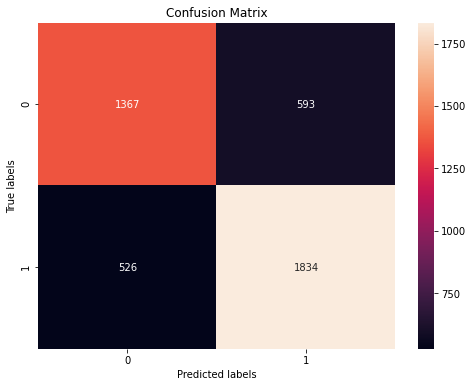

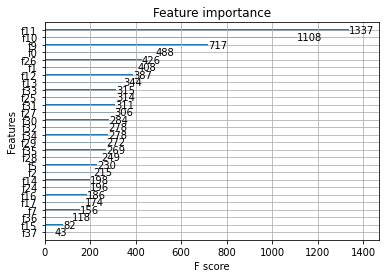

In [143]:
#define discount dataset XGBoost for new customers
X=discount.drop(['success','customer_id', 'received','viewed', 'completed', 'amount','discount'], axis=1)
y=discount.success

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)


Randomized search..
[03:40:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:41:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:41:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[03:47:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:48:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:49:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:53:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:53:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:53:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:56:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:56:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:56:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:58:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:58:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:58:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

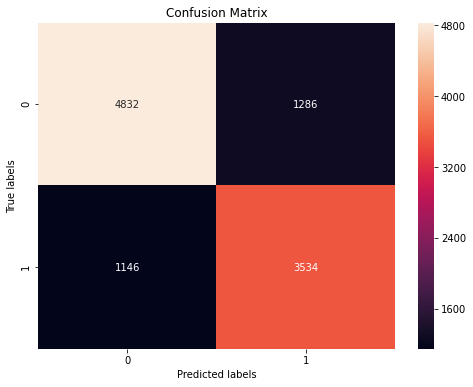

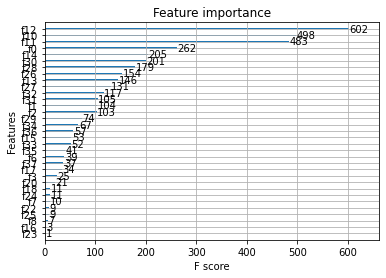

In [144]:
#define whole dataset XGBoost for new customers
X=re_check_data.drop(['success','customer_id', 'received','viewed', 'completed', 'amount'], axis=1)
y=re_check_data.success

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)

#### For existing customers

Randomized search..
[02:37:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:37:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:37:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[02:40:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:41:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:42:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:44:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:44:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:44:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:46:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:46:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:46:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:47:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:47:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:47:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

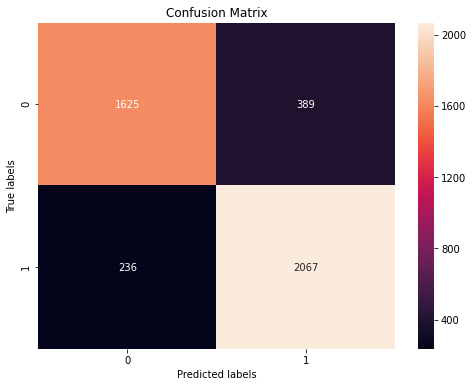

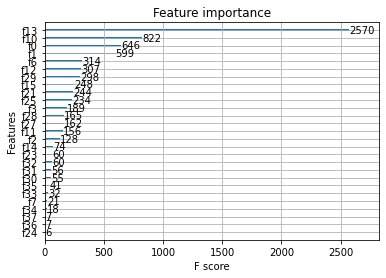

In [140]:
#define BOGO dataset XGBoost for Existing customers

X=bogo.drop(['success','customer_id', 'received', 'completed','bogo'], axis=1)
y=bogo.success

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)


Randomized search..
[02:48:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:48:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:48:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[02:52:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:53:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:54:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[02:58:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:58:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:59:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:02:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:02:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:02:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[03:04:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:04:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:04:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

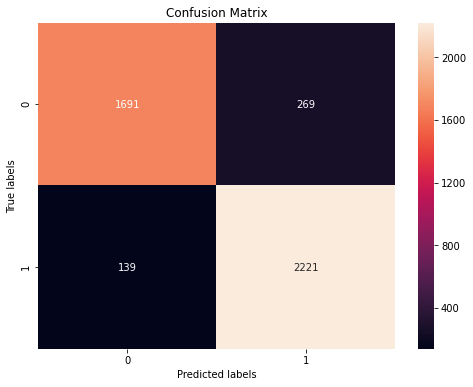

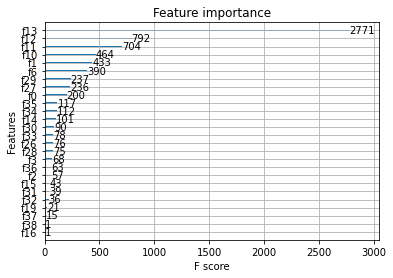

In [141]:
#define Discount dataset XGBoost for Existing customers
X=discount.drop(['success','customer_id', 'received', 'completed', 'discount'], axis=1)
y=discount.success

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)


Randomized search..
[03:59:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:59:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:59:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in 

[04:06:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:07:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:08:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[04:13:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:13:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:13:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[04:17:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:17:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:17:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[04:19:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:19:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:19:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

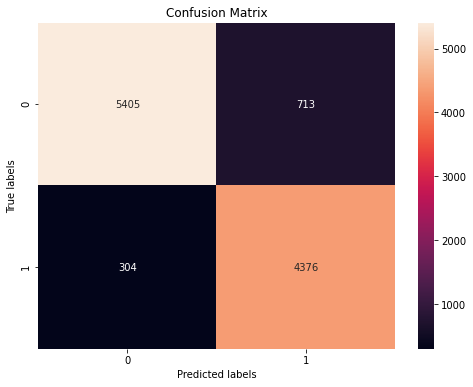

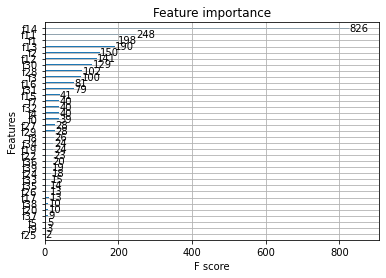

In [145]:
#define Discount dataset XGBoost for Existing customers

X=re_check_data.drop(['success','customer_id', 'received', 'completed'], axis=1)
y=re_check_data.success


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

model=XGBClassifierGrid(X_train, y_train)

model_yield(model, X,y)

# Results & Conclusion



### Model Evaluation and Validation

The model started with basic parameters of XGBoost, I use XGBoost here as it was giving the better precision used as compare to other models. I am removing the other models as it takes too much time to run them all and I've low processing power.

The model will work on three dataset first, preprocessed dataset, second, dataset that contains only bogo offers. Third, dataset contains only discount offers. Since, informational dataset has no offer as such, we are not considering it. The objective of the model is if there's would be a sale on the offer or not, it would be denoted by success.

Then we divide the modelling into two parts. Type 1, model for existing customer which will have viewed, amount details of the customer from transcript dataset. Type 2, model for new customers where the information about viewed, received, completed, amount is not available.

### Result

From the model, it is clear that amount is the biggest predictor for existing customer, and email is the biggest predictor for new customer, which is obvious as existing members who have purchased in large number before are likely to buy again when motivated through an offer. In case of new customer, we have already seen in Exploratory data analysis. The highest number of communication made is through email.

## Evaluation Metrics

The evaluation metrics used here are classification report and confusion metrics.

The model performed well for the existing customer as we have more details available for them. The accuracy for the XGBClassifier is more than 90% test accuracy and f1 score of 0.8955 for successful sale in whole dataset.For the new customer; However, we got f1 score 0.7375 for successful sale in whole dataset and after refinement it increases to 0.7440. To analyse this, we have to refer to the formula for Precision, Recall and F1 score:


#### Recall or Sensitivity or TPR (True Positive Rate):
According to scikit-learn documentation, the recall is intuitively the ability of the classifier to find all the positive samples.

Number of items correctly identified as positive out of total true positives: True Positives /(True Positives +False Negatives)


#### Precision:
According to the scikit-learn documentation, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.
Number of items correctly identified as positive out of total items identified as positive: True Positives /(True Positives + False Positives)


#### F1 Score:
The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall. A measure reaches its best value at 1 and its worst score at 0. With , and are equivalent, and the recall and the precision are equally important.

The formula is given by the harmonic mean of precision and recall: F1 = 2PrecisionRecall/(Precision + Recall)

The difference between F1 score vs accuracy indicates that there could be instances where the model have falsely classifying negatives as positives, likely due to the imbalance of classes. But the overall higher recall/accuracy compared to F1 score indicates that the model is predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes.

However, recalling our use case, we perhaps are not as concerned with the  mis-classification since we would rather not miss anyone on which an offer would have been effective. we don't mind sending people more offers than the ones liked by our customers.

### Conclusion 

1.The offers which are not on social media are least popular among the population. if we start sending these offers via social channel as well there might be some increase in total conversion for these offers.

2.It can be interpreted that for males, the buying frequency is high, however, the amount spent by them remains low. Offers that attract them to spend more can be created around the point where the curve starts to rise again. A similar attempt can be made for 'others' gender. That would increase the sales volume

For female customers, we need to increase the frequency as the average spending amount is more than male. We need to create offers with lower validity (duration) and lower difficulties similar to two top viewed as well as completed offers. This will increase the frequency

Some tailor-made age-specific offers need to be generated accordingly. We need to provide low-amount offers to the lower-age customers, and for the others, there is a need to mind the curve and create offers around the mean point which will increase the frequency of customers who tend to spend more.

3.When offers are completed by users without viewing them indicate that they had no intention to complete the offer, instead they were going to purchase the product irrespective of the communication. The offer was counted as utilized only because it was sent to them. If such offers are not sent, it can directly count as increased revenue for the company. So it is safe to assume such an amount as loss.Below are the details about the loss group and no interaction group.

###  Reflection: Areas of interest

We’ve divided the the group offerwise with respect to age and gender to identify correct target groups. 

This contains two parts, first where y limits are fixed, it gives us an idea what to look into which age/gender group needs to be targeted for particular offer.

 The highest loss belongs to 78-88 offer name 4, this implies that the offer is least used the age group. Inversely offer 7,8, 3 and 2 has the lowest loss which implies that these offers are aggressively used by the customers. 

These graphs will provide us a guideline for target group for each user. We can then send the offer accordingly. 
 
Since, the some offers has very minute details with rigid y limit let’s make it flexible to get better details about each offer.

For example, while looking into the data is clear that for offer 7 (88-98) age group has the highest loss which is not true for other famous offers. For example, for offer 8 Male aged 78-88 has the highest loss. We will look into the no interaction data to find better offer for the group

Apart from this, there’s another group of people who has no interaction i.e, the customers that aren’t viewing the offer as well as not completing it. The company is not getting any revenue generated by sending the offers to this group of customers. The reason behind it might be wrong target group for the offer.


For example offer 4 has the lowest interaction as compare to the other offers. And offer 2 has the highest interaction for the age (78-88) male group so we can send that group this offer as compare to offer 8 which has the highest loss for the group


### Improvements

We could use customer membership duration as a paramenter in model as it will make more sense. Customer who are member for long duration are more familiar with the app and might have used an offer before which make it easier for them go for another offer.
It will surely going to increase model efficiency